# Predicting Wildfire Causes

In [66]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn import tree, preprocessing
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor as dtr

# Import required libraries for performance metrics
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss,confusion_matrix, plot_confusion_matrix

from sklearn.model_selection import cross_validate

import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import KFold

### Data Loading

In [6]:
conn = sqlite3.connect('RDS-2013-0009.4_SQLITE/Data/FPA_FOD_20170508.sqlite')
#Please download "RDS-2013-0009.4_SQLITE.zip" from link: https://www.fs.usda.gov/rds/archive/Catalog/RDS-2013-0009.4/

In [7]:
# df = pd.read_sql_query("SELECT * FROM 'Fires'", conn)
# print(df.head())


In [8]:
# print(df.columns)

In [9]:
df = pd.read_sql_query("SELECT FIRE_YEAR,STAT_CAUSE_DESCR, STAT_CAUSE_CODE, LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,DISCOVERY_DOY,FIRE_SIZE,DISCOVERY_TIME, FIPS_CODE, CONT_DATE, OWNER_DESCR FROM 'Fires'", conn)
print(df.head())

   FIRE_YEAR STAT_CAUSE_DESCR  STAT_CAUSE_CODE   LATITUDE   LONGITUDE STATE  \
0       2005    Miscellaneous              9.0  40.036944 -121.005833    CA   
1       2004        Lightning              1.0  38.933056 -120.404444    CA   
2       2004   Debris Burning              5.0  38.984167 -120.735556    CA   
3       2004        Lightning              1.0  38.559167 -119.913333    CA   
4       2004        Lightning              1.0  38.559167 -119.933056    CA   

   DISCOVERY_DATE  DISCOVERY_DOY  FIRE_SIZE DISCOVERY_TIME FIPS_CODE  \
0       2453403.5             33       0.10           1300       063   
1       2453137.5            133       0.25           0845       061   
2       2453156.5            152       0.10           1921       017   
3       2453184.5            180       0.10           1600       003   
4       2453184.5            180       0.10           1600       003   

   CONT_DATE       OWNER_DESCR  
0  2453403.5              USFS  
1  2453137.5              

### Data Preprocessing and EDA

In [10]:
#Alter / Standardize few column
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
df['DAY_OF_WEEK'] = df['DATE'].dt.day_name()
df['DISCOVERY_TIME'].fillna(pd.to_numeric(df['DISCOVERY_TIME'].dropna()).mean(), inplace=True)
df['CONT_TIME'] = df['CONT_DATE'] - df['DISCOVERY_DATE']
print(df.head())


   FIRE_YEAR STAT_CAUSE_DESCR  STAT_CAUSE_CODE   LATITUDE   LONGITUDE STATE  \
0       2005    Miscellaneous              9.0  40.036944 -121.005833    CA   
1       2004        Lightning              1.0  38.933056 -120.404444    CA   
2       2004   Debris Burning              5.0  38.984167 -120.735556    CA   
3       2004        Lightning              1.0  38.559167 -119.913333    CA   
4       2004        Lightning              1.0  38.559167 -119.933056    CA   

   DISCOVERY_DATE  DISCOVERY_DOY  FIRE_SIZE DISCOVERY_TIME FIPS_CODE  \
0       2453403.5             33       0.10           1300       063   
1       2453137.5            133       0.25           0845       061   
2       2453156.5            152       0.10           1921       017   
3       2453184.5            180       0.10           1600       003   
4       2453184.5            180       0.10           1600       003   

   CONT_DATE       OWNER_DESCR       DATE  MONTH DAY_OF_WEEK  CONT_TIME  
0  2453403.5      

In [12]:
#Dropping null values. Also, Combining state fips code to the original fips code.
df = df.dropna(subset=['FIPS_CODE'], axis=0)
df = df.dropna()


FIPS = {
    'NM': '35',
    'OR': '41',
    'WY': '56',
    'CA': '06',
    'CO': '08',
    'ID': '16',
    'MT': '30',
    'NV': '32',
    'AZ': '04',
    'UT': '49',
    'WA': '53',
}

df['STATEWISE_FIPS'] = df['STATE'].map(FIPS)
df['FIPS'] = df[['STATEWISE_FIPS', 'FIPS_CODE']].apply(''.join, axis=1)

In [13]:
#Drop not needed columns
df.drop(columns=['FIPS_CODE', 'STATEWISE_FIPS'], inplace=True)
df = df.drop('DISCOVERY_DATE',axis=1)
df = df.drop('CONT_DATE',axis=1)

In [14]:
print(df.head())

   FIRE_YEAR STAT_CAUSE_DESCR  STAT_CAUSE_CODE   LATITUDE   LONGITUDE STATE  \
0       2005    Miscellaneous              9.0  40.036944 -121.005833    CA   
1       2004        Lightning              1.0  38.933056 -120.404444    CA   
2       2004   Debris Burning              5.0  38.984167 -120.735556    CA   
3       2004        Lightning              1.0  38.559167 -119.913333    CA   
4       2004        Lightning              1.0  38.559167 -119.933056    CA   

   DISCOVERY_DOY  FIRE_SIZE DISCOVERY_TIME       OWNER_DESCR       DATE  \
0             33       0.10           1300              USFS 2005-02-02   
1            133       0.25           0845              USFS 2004-05-12   
2            152       0.10           1921  STATE OR PRIVATE 2004-05-31   
3            180       0.10           1600              USFS 2004-06-28   
4            180       0.10           1600              USFS 2004-06-28   

   MONTH DAY_OF_WEEK  CONT_TIME   FIPS  
0      2   Wednesday        0.0  

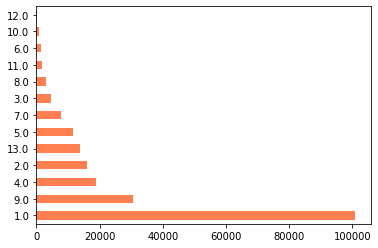

In [15]:
df['STAT_CAUSE_CODE'].value_counts().plot(kind='barh',color='coral')

plt.show()

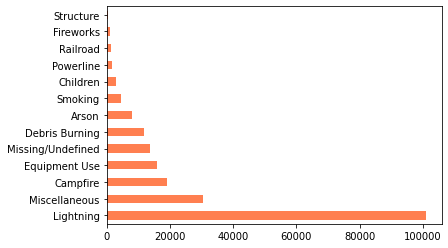

In [16]:
df['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral')
plt.show()

In [17]:
#Drop rows that have STAT_CAUSE_CODE ==9 || STAT_CUSE_DESCR == 13 because it represents Missing/Undefined, Miscellaneous.
df['STAT_CAUSE_CODE'] = df['STAT_CAUSE_CODE'].astype(int)
~((df['STAT_CAUSE_CODE'] == 13) | (df['STAT_CAUSE_CODE'] == 9))
df = df[~((df['STAT_CAUSE_CODE'] == 13) | (df['STAT_CAUSE_CODE'] == 9))]
print(df.head())





   FIRE_YEAR STAT_CAUSE_DESCR  STAT_CAUSE_CODE   LATITUDE   LONGITUDE STATE  \
1       2004        Lightning                1  38.933056 -120.404444    CA   
2       2004   Debris Burning                5  38.984167 -120.735556    CA   
3       2004        Lightning                1  38.559167 -119.913333    CA   
4       2004        Lightning                1  38.559167 -119.933056    CA   
5       2004        Lightning                1  38.635278 -120.103611    CA   

   DISCOVERY_DOY  FIRE_SIZE DISCOVERY_TIME       OWNER_DESCR       DATE  \
1            133       0.25           0845              USFS 2004-05-12   
2            152       0.10           1921  STATE OR PRIVATE 2004-05-31   
3            180       0.10           1600              USFS 2004-06-28   
4            180       0.10           1600              USFS 2004-06-28   
5            182       0.10           1800              USFS 2004-06-30   

   MONTH DAY_OF_WEEK  CONT_TIME   FIPS  
1      5   Wednesday        0.0  

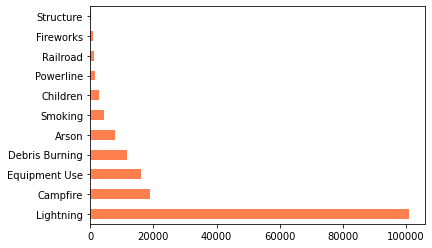

In [18]:
df['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral')
plt.show()

### Model Prep

In [19]:
#Scaling the values 
le = preprocessing.LabelEncoder()
df['STATE'] = le.fit_transform(df['STATE'])

df['DAY_OF_WEEK'] = le.fit_transform(df['DAY_OF_WEEK'])
df['FIPS'] = le.fit_transform(df['FIPS'])
df['OWNER_DESCR'] = le.fit_transform(df['OWNER_DESCR'])
df = df.dropna()
print(df.head())

   FIRE_YEAR STAT_CAUSE_DESCR  STAT_CAUSE_CODE   LATITUDE   LONGITUDE  STATE  \
1       2004        Lightning                1  38.933056 -120.404444      1   
2       2004   Debris Burning                5  38.984167 -120.735556      1   
3       2004        Lightning                1  38.559167 -119.913333      1   
4       2004        Lightning                1  38.559167 -119.933056      1   
5       2004        Lightning                1  38.635278 -120.103611      1   

   DISCOVERY_DOY  FIRE_SIZE DISCOVERY_TIME  OWNER_DESCR       DATE  MONTH  \
1            133       0.25           0845           14 2004-05-12      5   
2            152       0.10           1921           11 2004-05-31      5   
3            180       0.10           1600           14 2004-06-28      6   
4            180       0.10           1600           14 2004-06-28      6   
5            182       0.10           1800           14 2004-06-30      6   

   DAY_OF_WEEK  CONT_TIME  FIPS  
1            6        

In [20]:
#df = df.drop('STAT_CAUSE_DESCR',axis=1)


In [21]:
df = df.drop('DATE',axis=1)


In [22]:
df = df.drop('STAT_CAUSE_CODE',axis=1)
df_label = df
#Putting all the causes into 4 different categories, since there are so many of them. 
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    human = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning','Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in human:
        cause = 2
    else:
        cause = 3
    return cause

df_label['LABEL'] = df_label['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x)) # I created a copy of the original df earlier in the kernel
df_drop_month_3 = df_label.drop('STAT_CAUSE_DESCR',axis=1)
print(df_drop_month_3.head())

   FIRE_YEAR   LATITUDE   LONGITUDE  STATE  DISCOVERY_DOY  FIRE_SIZE  \
1       2004  38.933056 -120.404444      1            133       0.25   
2       2004  38.984167 -120.735556      1            152       0.10   
3       2004  38.559167 -119.913333      1            180       0.10   
4       2004  38.559167 -119.933056      1            180       0.10   
5       2004  38.635278 -120.103611      1            182       0.10   

  DISCOVERY_TIME  OWNER_DESCR  MONTH  DAY_OF_WEEK  CONT_TIME  FIPS  LABEL  
1           0845           14      5            6        0.0    44      1  
2           1921           11      5            1        0.0    23      2  
3           1600           14      6            1        5.0    16      1  
4           1600           14      6            1        5.0    16      1  
5           1800           14      6            6        1.0    17      1  


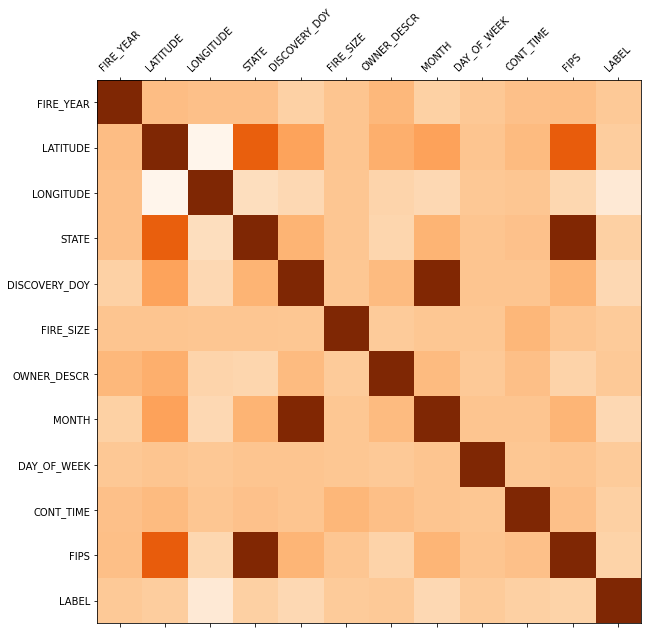

In [23]:
def plot_corr(df,size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr,cmap=plt.cm.Oranges)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)    
    plt.show()
    

plot_corr(df_drop_month_3)

In [24]:
df_drop_month_3 = df_drop_month_3.drop('STATE',axis=1)

In [25]:
df_drop_month_3 = df_drop_month_3.drop('OWNER_DESCR',axis=1)

In [26]:
df_drop_month_3 = df_drop_month_3.drop('MONTH',axis=1)

In [27]:
y_label = df_drop_month_3['LABEL'].values
X_label = df_drop_month_3.drop(['LABEL'], axis=1).values
Xscaled = scale(X_label)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(Xscaled,y_label,test_size=0.20, random_state=0)

### KNN Classifier

In [35]:
KNC = KNeighborsClassifier(n_neighbors = 7)
KNC.fit(X_train_3, y_train_3)
print(KNC.score(X_train_3, y_train_3))
print(KNC.score(X_test_3, y_test_3))

0.8685726701280408
0.8338577721837633


### Decision Tree Classifier

In [28]:
model = tree.DecisionTreeClassifier(criterion = 'gini', 
                            max_depth = 200, 
                            min_samples_split = 100, 
                            min_samples_leaf = 10)
dt = model.fit(X_train_3, y_train_3)

In [29]:
# Print scores
print(f'Score on training set: {dt.score(X_train_3, y_train_3)}')
print(f'Score on testing set: {dt.score(X_test_3, y_test_3)}')

Score on training set: 0.8690596600061435
Score on testing set: 0.847762893703737


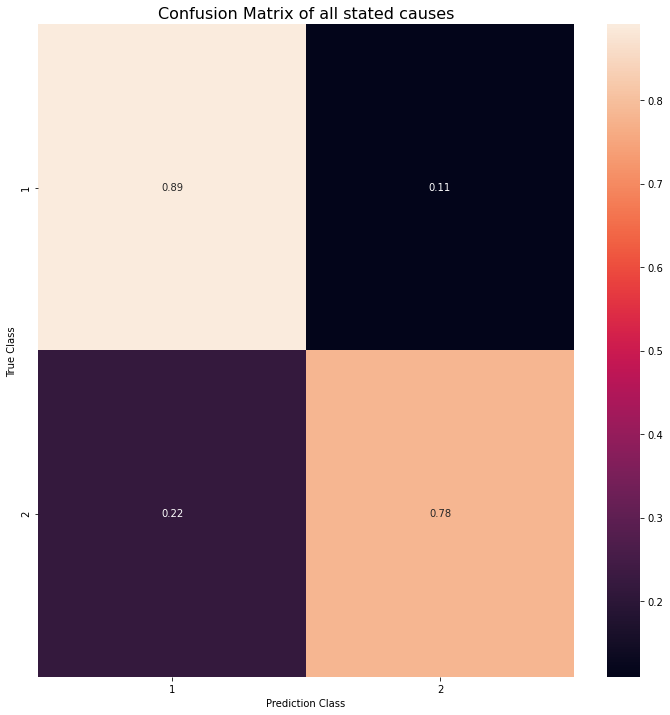

In [34]:
def plot_confusion_matrix(y_test, X_test, model):
    preds = model.predict(X_test)
    plt.figure(figsize = (12,12))
    plt.title('Confusion Matrix of all stated causes', fontdict = {'fontsize':16})

    sns.heatmap(confusion_matrix(y_test, 
                                 preds, 
                                 labels = [1,  2], 
                                 normalize = 'true'), annot = True)
    plt.xlabel('Prediction Class')
    plt.ylabel('True Class')
    plt.xticks(ticks = [i - 0.5 for i in range(1,3)], labels = [1,  2]);
    plt.yticks(ticks = [i - 0.5 for i in range(1,3)], labels = [1,  2]);

plot_confusion_matrix(y_test_3, X_test_3, dt)

### RandomForest Classifier

In [36]:

rf = RandomForestClassifier(n_estimators = 50, 
                            max_depth = 100, 
                            min_samples_split = 100, 
                            min_samples_leaf =40)

rf_dt = rf.fit(X_train_3, y_train_3)

print(f'Score on training set: {rf_dt.score(X_train_3, y_train_3)}')
print(f'Score on testing set: {rf_dt.score(X_test_3, y_test_3)}')

Score on training set: 0.8659429247862863
Score on testing set: 0.8554047169528605


### Adaboost Classifier

In [37]:
ada = AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(max_depth = 2), n_estimators = 30)
ada.fit(X_train_3, y_train_3)
ada.score(X_train_3, y_train_3)

0.8250507593296023

In [38]:
print(f'Score on training set: {ada.score(X_train_3, y_train_3)}')
print(f'Score on testing set: {ada.score(X_test_3, y_test_3)}')

Score on training set: 0.8250507593296023
Score on testing set: 0.8245677125475741


### Logistic Regression

In [39]:
#  logistic regression model
lr = LogisticRegression(solver='lbfgs', 
                           penalty='l2', 
                           multi_class='multinomial', 
                           C=.9, 
                           max_iter=500, 
                           n_jobs=3)
lr_dt = lr.fit(X_train_3, y_train_3)

# Print scores
print(f'Score on training set: {lr_dt.score(X_train_3, y_train_3)}')
print(f'Score on testing set: {lr_dt.score(X_test_3, y_test_3)}')


Score on training set: 0.6848501194998239
Score on testing set: 0.6849471065959424


### Decision Tree Regression

In [40]:
reg = dtr(random_state = 42)
reg_dt = reg.fit(X_train_3, y_train_3)


# Print scores
print(f'Score on training set: {reg_dt.score(X_train_3, y_train_3)}')
print(f'Score on testing set: {reg_dt.score(X_test_3, y_test_3)}')


# y_pred = reg.predict(X_test)
# print(‘MSE =’, mse(y_pred, y_test))
# print(‘MAE =’, mae(y_pred, y_test))
# print(‘R2 Score =’, r2_score(y_pred, y_test))

Score on training set: 1.0
Score on testing set: 0.2848994446288402


### Evaluating and Comparing the Classification Models

In [41]:
# Define dictionary with performance metrics
scoring = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score), 
           'f1_score':make_scorer(f1_score)}

In [42]:
# Instantiate the machine learning classifiers
log_model = LogisticRegression(solver='lbfgs', 
                           penalty='l2', 
                           multi_class='multinomial', 
                           C=.9, 
                           max_iter=500, 
                           n_jobs=3)
knc_model = KNeighborsClassifier(n_neighbors = 7)
dtr_model = tree.DecisionTreeClassifier(criterion = 'gini', 
                            max_depth = 200, 
                            min_samples_split = 100, 
                            min_samples_leaf = 10)
rfc_model = RandomForestClassifier(n_estimators = 50, 
                            max_depth = 100, 
                            min_samples_split = 100, 
                            min_samples_leaf =40)
ada_model = AdaBoostClassifier(base_estimator = 
                               tree.DecisionTreeClassifier
                               (max_depth = 2), n_estimators = 30)




In [51]:
# Define the models evaluation function
def models_evaluation(X, y, folds):
    
    '''
    X : data set features
    y : data set target
    folds : number of cross-validation folds
    
    '''
    
    # Perform cross-validation to each machine learning classifier
    log = cross_validate(log_model, X, y, cv=folds, scoring=scoring)
    knc = cross_validate(knc_model, X, y, cv=folds, scoring=scoring)
    dtr = cross_validate(dtr_model, X, y, cv=folds, scoring=scoring)
    rfc = cross_validate(rfc_model, X, y, cv=folds, scoring=scoring)
    ada = cross_validate(ada_model, X, y, cv=folds, scoring=scoring)

    # Create a data frame with the models perfoamnce metrics scores
    models_scores_table = pd.DataFrame({'Logistic Regression':[log['test_accuracy'].mean(),
                                                               log['test_precision'].mean(),
                                                               log['test_recall'].mean(),
                                                               log['test_f1_score'].mean()],
                                       
                                      'K Nearest Neighbor Classifier':[knc['test_accuracy'].mean(),
                                                                   knc['test_precision'].mean(),
                                                                   knc['test_recall'].mean(),
                                                                   knc['test_f1_score'].mean()],
                                       
                                      'Decision Tree':[dtr['test_accuracy'].mean(),
                                                       dtr['test_precision'].mean(),
                                                       dtr['test_recall'].mean(),
                                                       dtr['test_f1_score'].mean()],
                                       
                                      'Random Forest':[rfc['test_accuracy'].mean(),
                                                       rfc['test_precision'].mean(),
                                                       rfc['test_recall'].mean(),
                                                       rfc['test_f1_score'].mean()],
                                       
                                      'AdaBoost':[ada['test_accuracy'].mean(),
                                                              ada['test_precision'].mean(),
                                                              ada['test_recall'].mean(),
                                                              ada['test_f1_score'].mean()]},
                                      
                                      index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
    # Add 'Best Score' column
    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)
    
    # Return models performance metrics scores data frame
    return(models_scores_table)
  
    

In [52]:
# Run models_evaluation function
models_evaluation(Xscaled,y_label , 5)

,Logistic Regression,K Nearest Neighbor Classifier,Decision Tree,Random Forest,AdaBoost,Best Score
Accuracy,0.641355,0.645239,0.614934,0.642619,0.645442,AdaBoost
Precision,0.672960,0.722620,0.734189,0.783737,0.785844,AdaBoost
Recall,0.805050,0.700412,0.604934,0.639103,0.649089,Logistic Regression
F1 Score,0.729907,0.701730,0.604991,0.632276,0.629091,Logistic Regression


In [90]:
# Define the models evaluation function
def kfold_model_analysis(X, y, folds):
    
    '''
    X : data set features
    y : data set target
    folds : number of cross-validation folds
    
    '''
    
    # Perform cross-validation to each machine learning classifier
    log = cross_validate(log_model, X, y, cv=folds, scoring=scoring)
    knc = cross_validate(knc_model, X, y, cv=folds, scoring=scoring)
    dtr = cross_validate(dtr_model, X, y, cv=folds, scoring=scoring)
    rfc = cross_validate(rfc_model, X, y, cv=folds, scoring=scoring)
    ada = cross_validate(ada_model, X, y, cv=folds, scoring=scoring)

    # Create a data frame with the models perfoamnce metrics scores
    models_scores_table = pd.DataFrame({
        
                                     'Logistic Regression':[log['test_accuracy'].mean(),
                                                               log['test_precision'].mean(),
                                                               log['test_recall'].mean(),
                                                               log['test_f1_score'].mean()],
                                       
                                      'K Nearest Neighbor Classifier':[knc['test_accuracy'].mean(),
                                                                   knc['test_precision'].mean(),
                                                                   knc['test_recall'].mean(),
                                                                   knc['test_f1_score'].mean()],
                                       
                                      'Decision Tree':[dtr['test_accuracy'].mean(),
                                                       dtr['test_precision'].mean(),
                                                       dtr['test_recall'].mean(),
                                                       dtr['test_f1_score'].mean()],
                                       
                                      'Random Forest':[rfc['test_accuracy'].mean(),
                                                       rfc['test_precision'].mean(),
                                                       rfc['test_recall'].mean(),
                                                       rfc['test_f1_score'].mean()],
                                       
                                      'AdaBoost':[ada['test_accuracy'].mean(),
                                                              ada['test_precision'].mean(),
                                                              ada['test_recall'].mean(),
                                                              ada['test_f1_score'].mean()]},
                                      
                                      index=['Accuracy', 'Precision', 'Recall', 'F1 Score']
        )
    
    # Add 'Best Score' column
    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)
    
    # Return models performance metrics scores data frame
    return(models_scores_table)
  
    

In [91]:
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
kfold_model_analysis(Xscaled,y_label , kfold)

,Logistic Regression,K Nearest Neighbor Classifier,Decision Tree,Random Forest,AdaBoost,Best Score
Accuracy,0.684618,0.832578,0.846621,0.856265,0.823240,Random Forest
Precision,0.705802,0.833042,0.857991,0.861054,0.831341,Random Forest
Recall,0.820884,0.904570,0.894544,0.909135,0.887992,Random Forest
F1 Score,0.759001,0.867331,0.875884,0.884439,0.858730,Random Forest
